# Neural style transfer

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2016/01/11<br>
**Last modified:** 2020/05/02<br>
**Description:** Transfering the style of a reference image to target image using gradient descent.

## Introduction

Style transfer consists in generating an image
with the same "content" as a base image, but with the
"style" of a different picture (typically artistic).
This is achieved through the optimization of a loss function
that has 3 components: "style loss", "content loss",
and "total variation loss":

- The total variation loss imposes local spatial continuity between
the pixels of the combination image, giving it visual coherence.
- The style loss is where the deep learning keeps in --that one is defined
using a deep convolutional neural network. Precisely, it consists in a sum of
L2 distances between the Gram matrices of the representations of
the base image and the style reference image, extracted from
different layers of a convnet (trained on ImageNet). The general idea
is to capture color/texture information at different spatial
scales (fairly large scales --defined by the depth of the layer considered).
- The content loss is a L2 distance between the features of the base
image (extracted from a deep layer) and the features of the combination image,
keeping the generated image close enough to the original one.

**Reference:** [A Neural Algorithm of Artistic Style](
  http://arxiv.org/abs/1508.06576)

## Setup

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19 # INSERT HERE

image_new = False
if image_new:
    base_image_path = keras.utils.get_file("jac.jpg", "https://i.imgur.com/Hyk9mT8.jpg")
    style_reference_image_path = keras.utils.get_file(
        "vvg.jpg", "https://i.imgur.com/MrGSSpa.jpg"
    )
    
else:
    base_image_path = '/home/demouser/.keras/datasets/jac.jpg'
    style_reference_image_path = '/home/demouser/.keras/datasets/vvg.jpg'


result_prefix = "resultados_iteraciones/vgg19/retrato_vgg19_" # INDICAR RUTA RESULTADOS

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

## Let's take a look at our base (content) image and our style reference image

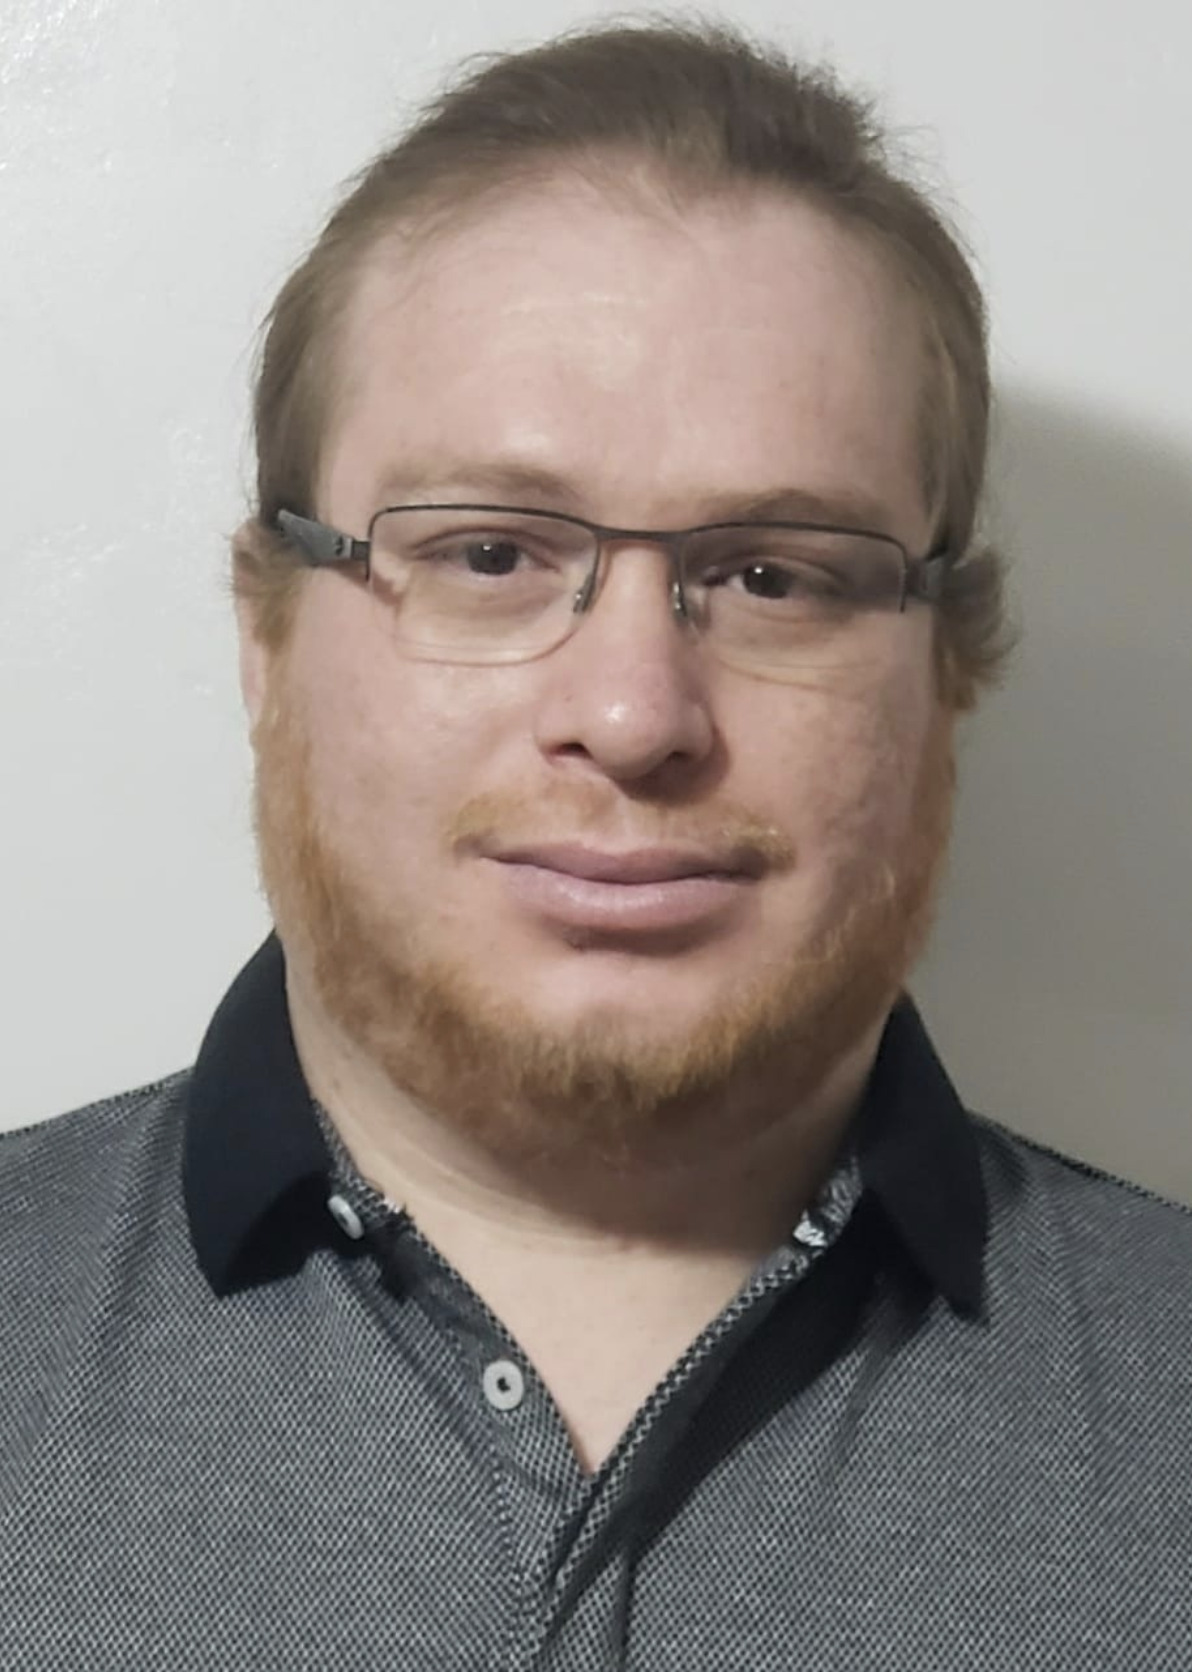

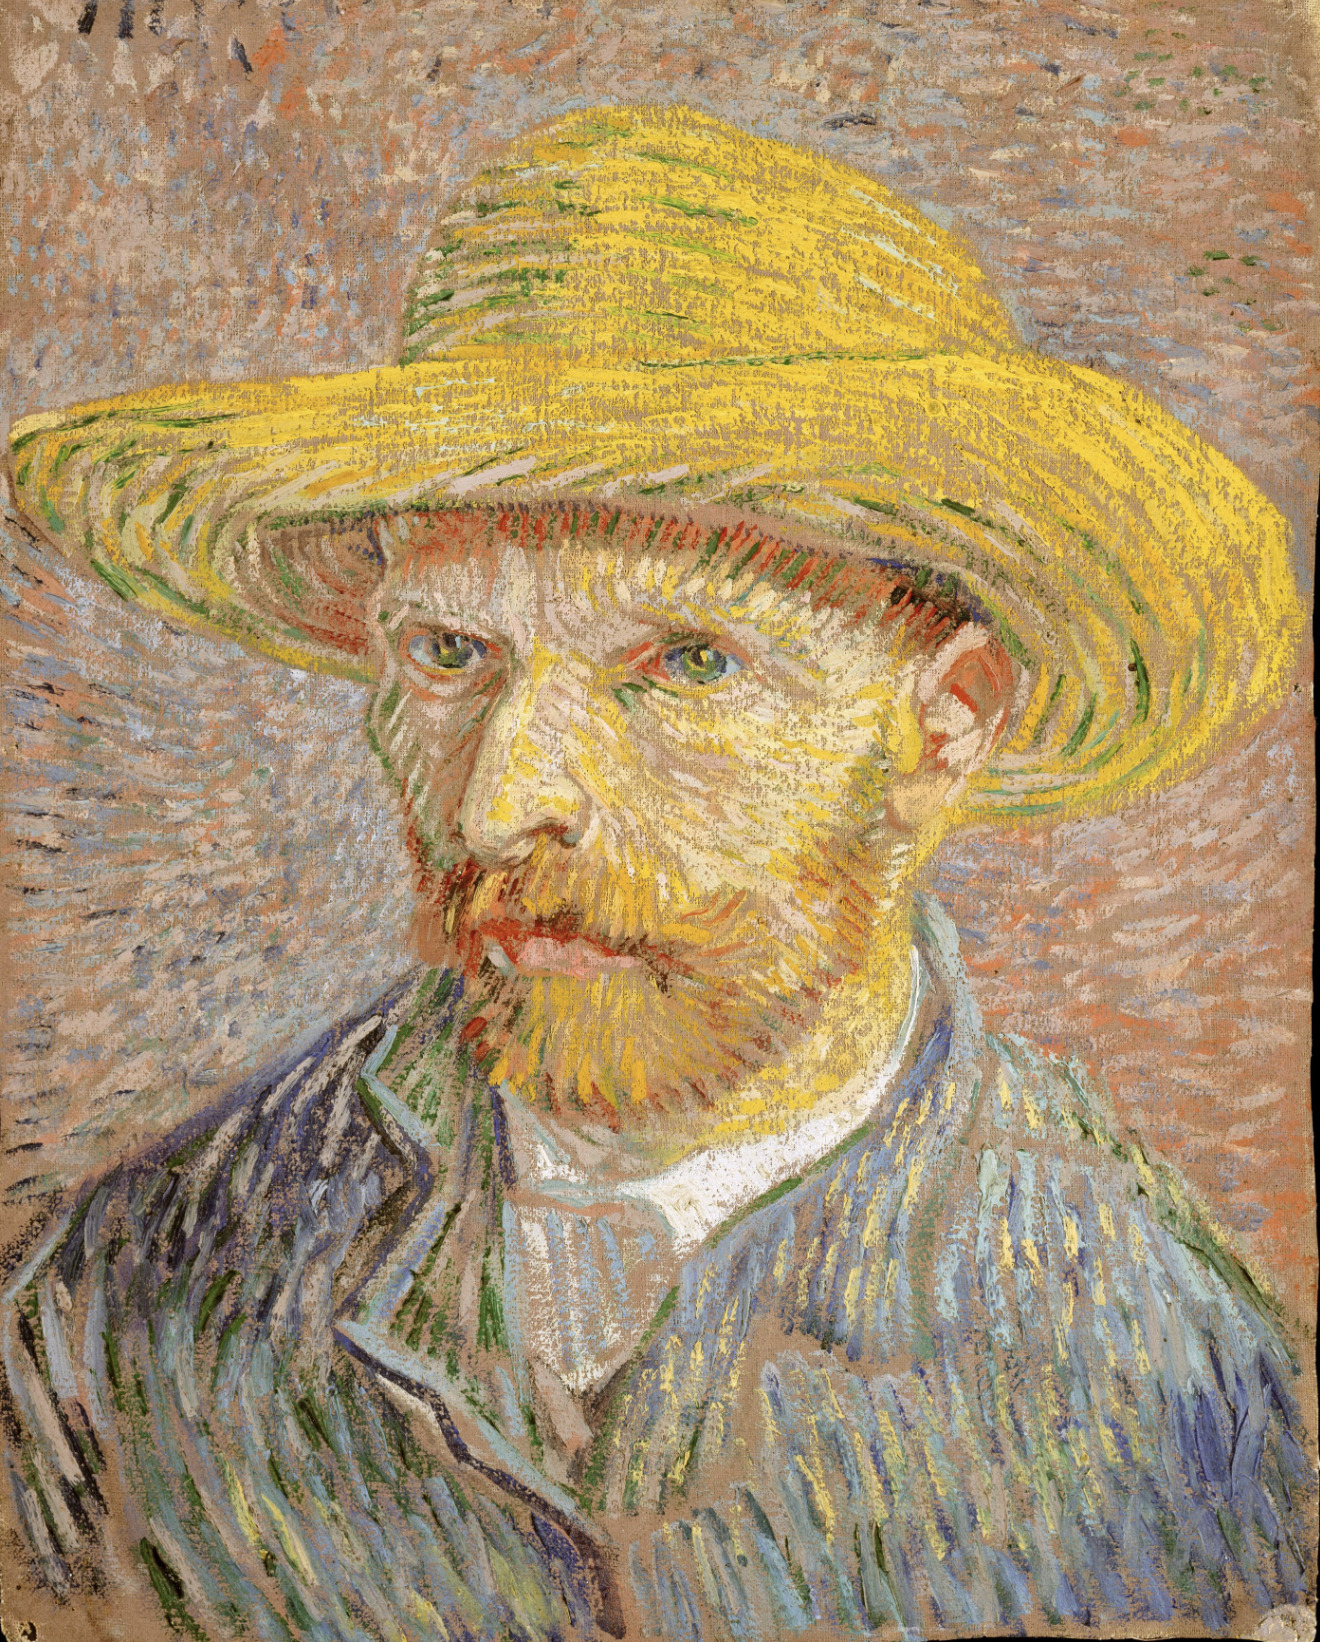

In [3]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

## Image preprocessing / deprocessing utilities

In [4]:

def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img) # insert here
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


## Compute the style transfer loss

First, we need to define 4 utility functions:

- `gram_matrix` (used to compute the style loss)
- The `style_loss` function, which keeps the generated image close to the local textures
of the style reference image
- The `content_loss` function, which keeps the high-level representation of the
generated image close to that of the base image
- The `total_variation_loss` function, a regularization loss which keeps the generated
image locally-coherent

In [5]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))


Next, let's create a feature extraction model that retrieves the intermediate activations
of VGG19 (as a dict, by name).

In [6]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False) # INSERT HERE

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

2022-12-08 15:54:35.545674: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 15:54:35.989501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14810 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5


Finally, here's the code that computes the style transfer loss.

In [7]:
# List of layers to use for the style loss.
# guardamos en layers.txt
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


## Add a tf.function decorator to loss & gradient computation

To compile it, and thus make it fast.

In [8]:

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads


## The training loop

Repeatedly run vanilla gradient descent steps to minimize the loss, and save the
resulting image every 100 iterations.

We decay the learning rate by 0.96 every 100 steps.

In [9]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

2022-12-08 15:54:37.759746: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-12-08 15:54:38.247452: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Iteration 100: loss=1335.60
Iteration 200: loss=1032.38
Iteration 300: loss=931.83
Iteration 400: loss=879.97
Iteration 500: loss=846.92
Iteration 600: loss=823.31
Iteration 700: loss=805.25
Iteration 800: loss=790.61
Iteration 900: loss=778.38
Iteration 1000: loss=767.97
Iteration 1100: loss=758.97
Iteration 1200: loss=751.12
Iteration 1300: loss=744.20
Iteration 1400: loss=738.02
Iteration 1500: loss=732.45
Iteration 1600: loss=727.40
Iteration 1700: loss=722.78
Iteration 1800: loss=718.55
Iteration 1900: loss=714.65
Iteration 2000: loss=711.07
Iteration 2100: loss=707.75
Iteration 2200: loss=704.66
Iteration 2300: loss=701.79
Iteration 2400: loss=699.12
Iteration 2500: loss=696.64
Iteration 2600: loss=694.33
Iteration 2700: loss=692.16
Iteration 2800: loss=690.12
Iteration 2900: loss=688.22
Iteration 3000: loss=686.42
Iteration 3100: loss=684.74
Iteration 3200: loss=683.15
Iteration 3300: loss=681.66
Iteration 3400: loss=680.25
Iteration 3500: loss=678.92
Iteration 3600: loss=677.65

After 4000 iterations, you get the following result:

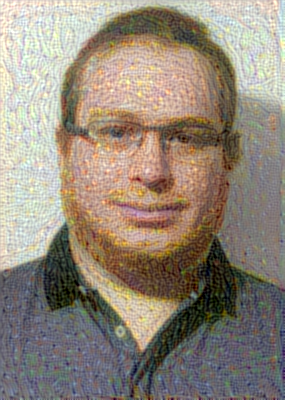

In [10]:
display(Image(result_prefix + "_at_iteration_4000.png"))

**Example available on HuggingFace**
| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Model-Neural%20style%20transfer-black.svg)](https://huggingface.co/keras-io/VGG19) | [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Spaces-Neural%20style%20transfer-black.svg)](https://huggingface.co/spaces/keras-io/neural-style-transfer) |

In [12]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     